In [1]:
#%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import astropy as ap
import astropy.table as at
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.constants import c
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

import pandas as pd

### Even though you are submitting these with `git` and this file tells you to rename it, and you should be pushing to a dedicated folder with your username, please also stick your name in this file here, so there's extra redundancy.

The point of this assignment is to:
- to make sure you have a sense of fluxes, magnitudes and distances as a function of redshift
- get familiar with drawing random numbers from a distribution, making cuts on your data
- modeling in the presence of systematic effects and the resulting biases you'll encounter

# Q1. The $k$-correction in the sub-mm and the optical (60 pts)

You know how to calculate the flux synthetically in some band, but what about comparing the flux of the same class of objects at different redshifts. Necessarily, you'll have to compare the rest-frame flux with the observer frame flux further in the red at some redshift $z$ because the Universe is expanding and frequency of photons is shifting.

To do this, you need the "$k$-correction" which is nicely summarized in Hogg et al. 2002: https://arxiv.org/abs/astro-ph/0210394
(You might start by looking at Eqn. 12, and comparing it to the synthetic integrals for the flux you implemented in Homework 1)

As we discussed in class (or as you might know if you've listened to a talk from Prof. Joaquin Vieira) galaxies have an interesting effect where the flux density $F_\nu$ from about 250$\mu m$ becomes roughly constant over a large range in redshift because you climb the Rayleigh-Jeans tail as you increase redshift, which compensates for the decrease in the flux density because of increasing distance. In the optical, you have no such luck, and indeed, depending on the class of galaxy, the $k$-correction means that galaxies in a fixed observer band might seem even fainter than you might expect from the inverse square law.

In particular, the $k$-correction goes negative.

In this problem, you'll implement the k-correction (reuse the code from HW1 and simplify Eqn 12).

I've included an SED of a galaxy ```aless_average_seds.dat``` from Elisabete de Cunha (you can read about it here: http://astronomy.swinburne.edu.au/~ecunha/ecunha/SED_Templates.html) with this homework. The columns are wavelength (in microns), average $F_\nu$ (in mJy), and upper and lower credible regions on the flux density.

Your mission is to make three plots (15 points each for the plot):

- Fig 1. should plot the flux density in mJy of this SED as a function of redshift (see here: https://ned.ipac.caltech.edu/level5/Sept04/Blain/Blain2_5.html) in common bands - assume perfectly rectangular bands with a fixed 3  micron bandwidth around the central wavelengths shown in the above figure. (Hint: this doesn't need you to actually compute the $k$-correction explicitly yet, but you will need to be careful about units and show that you know how to redshift and dim an SED). Evaluate this on a grid of redshift from $z$=1 to $z$=8 (inclusive) with $\Delta z$=0.25 spacing.

- Fig 2. should plot the flux density (in mJy) of the SED as a function of wavelength in microns (see the 2nd animation here: http://www.as.utexas.edu/~cmcasey/animated.html) over the same redshift grid (you can use $\Delta z$=0.50 to make it less cluttered if you like) and overplot the sub-mm bands for BICEP2 (http://svo2.cab.inta-csic.es/theory/fps3/index.php?mode=browse&gname=BICEP&gname2=BICEP2&asttype=)
  
- Fig 3. should plot the $k$-correction (in magnitudes) itself for LSST giy bands as a function of redshift between $z$=0. and $z=2$ in $\Delta z$=0.01 steps (you can use whatever linestyle you like to join the lines, but make sure you use a different color for each of the observer frames). The Hogg et al. 2002 will need you to specify a rest-frame filter for each of the observer frame filters. Use the same LSST ugrizy filter set and determine which one is at the closest effective wavelength to the observer frame filter's effective wavelength at each redshift. If there is no band that maps well to an observer frame band (i.e. the the rest-frame filter has redshifted out of the observer frame filter) stop computing the $k$-correction for that filter.

Hint: Astropy has a units module to help convert between different units and an equivalencies option particularly to convert between wavelengths and frequencies (https://docs.astropy.org/en/stable/units/equivalencies.html). You can try to do it by hand, but if you mess it up, you'll get rubbish. It also has a cosmology module to compute luminosity distance as a function of redshift - you can assume a Flat $\Lambda$CDM cosmology.

### This is not actually all that much code if you break it into a few functions.

In [3]:
!wget http://astronomy.swinburne.edu.au/~ecunha/ecunha/SED_Templates_files/aless_average_seds.dat

--2024-10-01 14:35:13--  http://astronomy.swinburne.edu.au/~ecunha/ecunha/SED_Templates_files/aless_average_seds.dat
Resolving astronomy.swinburne.edu.au (astronomy.swinburne.edu.au)... 136.186.1.60
Connecting to astronomy.swinburne.edu.au (astronomy.swinburne.edu.au)|136.186.1.60|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 800138 (781K)
Saving to: ‘aless_average_seds.dat.3’

aless_average_seds. 100%[===================>] 781.38K   617KB/s    in 1.3s    

2024-10-01 14:35:15 (617 KB/s) - ‘aless_average_seds.dat.3’ saved [800138/800138]



In [4]:
data = at.Table.read('aless_average_seds.dat', format='ascii', names=['wave (um)','fnu (mJy)', 'fnu_bright', 'fnu_faint'], data_start=1)

# we give units to wavelength and flux tables
data["fnu (mJy)"] *= u.mJy
data["wave (um)"] *= u.um

In [5]:
# Useful functions

def observed_wl(wl, z):
    # given a rest wavelength, returns the wl if object were at redshift z
    return wl*(1+z)

def observed_flux(flux, z):
    # given a rest flux, returns the flux if object were at redshift z
    # sources: https://arxiv.org/abs/1410.2281, https://ned.ipac.caltech.edu/level5/Sept04/Blain/Blain2_5.html
    # only valid for flux per unit wavelength
    return flux / (1+z)**4

## Plot 1

(29, 12)


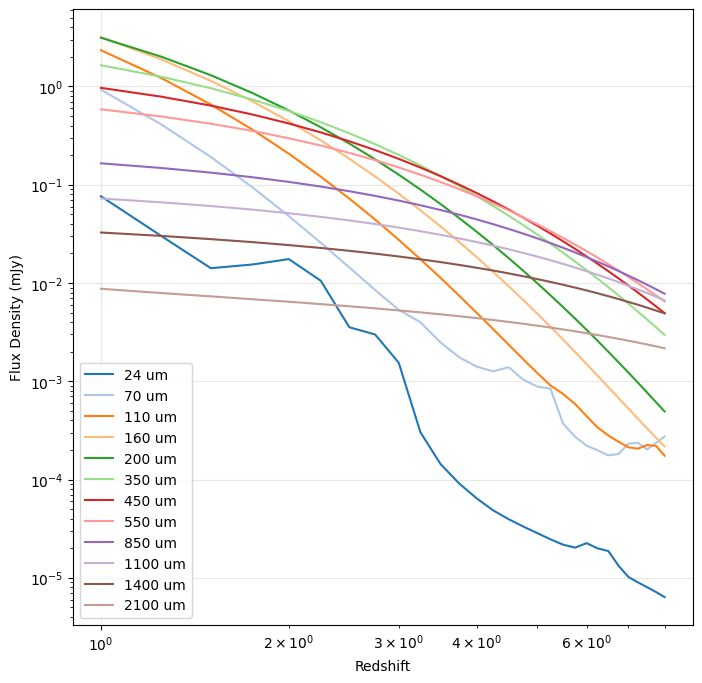

In [6]:
# Plot 1

# we want to calculate the flux density per unit frequency at each of the redshifts in the grid
z_grid = np.arange(1,8.25, 0.25)

# and multiply it by a filter transmission
band_centers=[24,70,110,160,200,350,450,550,850,1100,1400,2100]

# to do this, we need to calculate the observed wavelength and observed flux of the SED at each z
fluxes_by_z=[]
for z in z_grid:
    obs_wl=observed_wl(data["wave (um)"], z)
    obs_flux_density=observed_flux(data["fnu (mJy)"], z)
    flux_by_filter=[]
    for center in band_centers: # since some of the shifted fluxes have very low (or no) overlap with filter range, we interpolate the shifted sed inside the range of the filter
        filter_wl = np.linspace(center-1.5, center+1.5, 10) # wavelengths where filter trasmission is 1
        obs_flux_density_interp = np.interp(filter_wl, obs_wl, obs_flux_density) # flux density values inside the filter range, interpolated
        flux_filter = sp.integrate.simpson(y=obs_flux_density_interp, x=filter_wl) # integrated flux inside of filter wavelength range
        flux_by_filter.append(flux_filter)
    fluxes_by_z.append(flux_by_filter)

fluxes = np.array(fluxes_by_z)

print(fluxes.shape)

fig,ax=plt.subplots(figsize=(8,8))
cmap=plt.get_cmap('tab20') #colormap in order to have auto colors with more than 10 lines
for index, band in enumerate(band_centers):
    ax.plot(z_grid, fluxes[:,index], label=f"{band} um", color=cmap(index))
ax.set_xlabel("Redshift")
ax.set_ylabel("Flux Density (mJy)")
ax.legend()
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(alpha=0.3)
plt.show()

## Plot 2

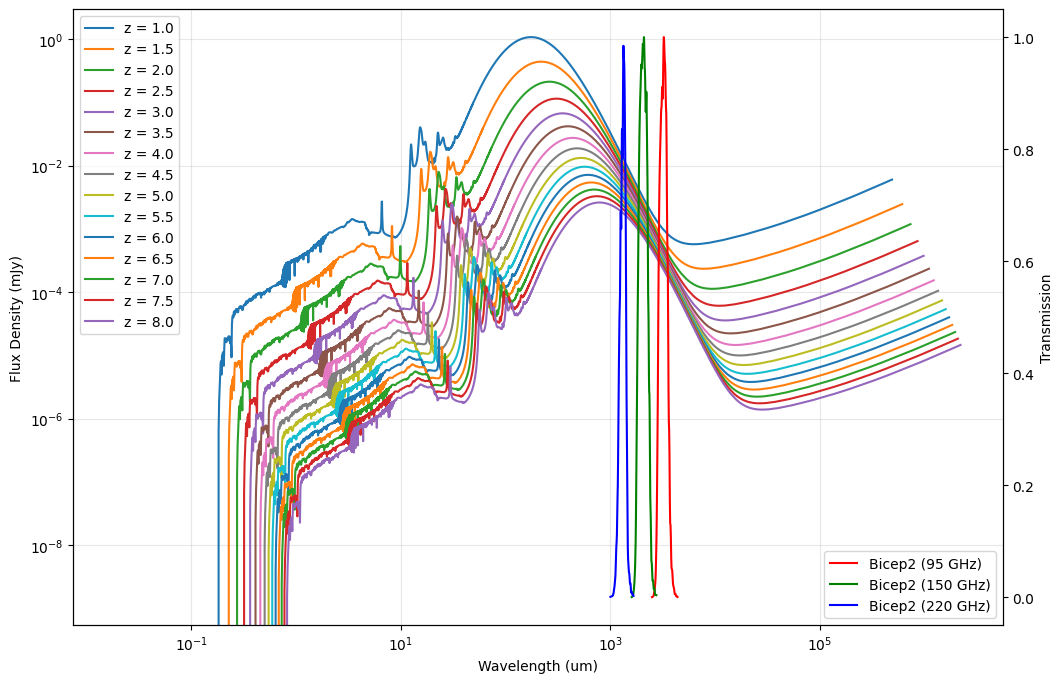

In [7]:
# Plot 2
# we use the functions defined for plot 1
# All we have to do is get the observed values for different redshifts

fig,ax = plt.subplots(figsize=(12,8))

z_grid = np.arange(1,8.5, 0.5)

for z in z_grid:
    ax.plot(observed_wl(data['wave (um)'], z), observed_flux(data['fnu (mJy)'], z), label=f"z = {z}")

ax.set_xlabel("Wavelength (um)")
ax.set_ylabel("Flux Density (mJy)")
ax.legend()
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(alpha=0.3)
ax.legend(loc=0)
#plt.show()

# now for the filters
bicep2_95 = at.Table.read("data/BICEP_BICEP2.95GHz.dat", format="ascii", names=("WL (AA)", "Transmission"))
bicep2_95["WL (AA)"] *= u.AA
bicep2_95["WL (um)"] = bicep2_95["WL (AA)"].to(u.um)

bicep2_150 = at.Table.read("data/BICEP_BICEP2.150GHz.dat", format="ascii", names=("WL (AA)", "Transmission"))
bicep2_150["WL (AA)"] *= u.AA
bicep2_150["WL (um)"] = bicep2_150["WL (AA)"].to(u.um)

bicep2_220 = at.Table.read("data/BICEP_BICEP2.220GHz.dat", format="ascii", names=("WL (AA)", "Transmission"))
bicep2_220["WL (AA)"] *= u.AA
bicep2_220["WL (um)"] = bicep2_220["WL (AA)"].to(u.um)

ax2=ax.twinx()
ax2.set_ylabel("Transmission")
ax2.plot(bicep2_95["WL (um)"], bicep2_95["Transmission"], c="red", label="Bicep2 (95 GHz)")
ax2.plot(bicep2_150["WL (um)"], bicep2_150["Transmission"], c="green", label="Bicep2 (150 GHz)")
ax2.plot(bicep2_220["WL (um)"], bicep2_220["Transmission"], c="blue", label="Bicep2 (220 GHz)")
ax2.legend(loc=4)

plt.show()

## Plot 3

In [8]:
# we start by using astropy units and equivalencies to create a columns for f_lambda
fnu = data["fnu (mJy)"].quantity
wavelength = data["wave (um)"].quantity

# to convert from f_nu to f_lambda, we use f_lambda = f_nu * c / lambda**2
# in these units, f_lambda should have units mJy*(m/s)*(um)**-2
# alternatively, we use astropy to do the conversion and require the final value to be in these units
f_lambda = fnu.to(u.mJy * u.m * u.s**-1 * u.um**-2, equivalencies=u.spectral_density(wavelength))

data["f_lambda"]=f_lambda
display(data)

wave (um),fnu (mJy),fnu_bright,fnu_faint,f_lambda
um,mJy,,,m mJy / (s um2)
float64,float64,float64,float64,float64
0.0094,0.0,0.0,0.0,0.0
0.0096,0.0,0.0,0.0,0.0
0.0098,0.0,0.0,0.0,0.0
0.01,0.0,0.0,0.0,0.0
0.01019,0.0,0.0,0.0,0.0
0.0104,0.0,0.0,0.0,0.0
0.0106,0.0,0.0,0.0,0.0
0.01079,0.0,0.0,0.0,0.0


In [9]:
# Then we get the LSST Filter Transmissions (ugrizy, filter only)
LSST_u_filter = at.Table.read("data/LSST_LSST.u_filter.dat", format="ascii", names=("WL (A)", "Transmission"))
LSST_u_filter['WL (A)'] *= u.AA
LSST_u_filter['WL (um)'] = LSST_u_filter['WL (A)'].to(u.um)
LSST_u_filter_eff_lambda = np.sum(LSST_u_filter['WL (um)'] * LSST_u_filter['Transmission']) / np.sum(LSST_u_filter['Transmission'])

LSST_g_filter = at.Table.read("data/LSST_LSST.g_filter.dat", format="ascii", names=("WL (A)", "Transmission"))
LSST_g_filter['WL (A)'] *= u.AA
LSST_g_filter['WL (um)'] = LSST_g_filter['WL (A)'].to(u.um)
LSST_g_filter_eff_lambda = np.sum(LSST_g_filter['WL (um)'] * LSST_g_filter['Transmission']) / np.sum(LSST_g_filter['Transmission'])

LSST_r_filter = at.Table.read("data/LSST_LSST.r_filter.dat", format="ascii", names=("WL (A)", "Transmission"))
LSST_r_filter['WL (A)'] *= u.AA
LSST_r_filter['WL (um)'] = LSST_r_filter['WL (A)'].to(u.um)
LSST_r_filter_eff_lambda = np.sum(LSST_r_filter['WL (um)'] * LSST_r_filter['Transmission']) / np.sum(LSST_r_filter['Transmission'])

LSST_i_filter = at.Table.read("data/LSST_LSST.i_filter.dat", format="ascii", names=("WL (A)", "Transmission"))
LSST_i_filter['WL (A)'] *= u.AA
LSST_i_filter['WL (um)'] = LSST_i_filter['WL (A)'].to(u.um)
LSST_i_filter_eff_lambda = np.sum(LSST_i_filter['WL (um)'] * LSST_i_filter['Transmission']) / np.sum(LSST_i_filter['Transmission'])

LSST_z_filter = at.Table.read("data/LSST_LSST.z_filter.dat", format="ascii", names=("WL (A)", "Transmission"))
LSST_z_filter['WL (A)'] *= u.AA
LSST_z_filter['WL (um)'] = LSST_z_filter['WL (A)'].to(u.um)
LSST_z_filter_eff_lambda = np.sum(LSST_z_filter['WL (um)'] * LSST_z_filter['Transmission']) / np.sum(LSST_z_filter['Transmission'])

LSST_y_filter = at.Table.read("data/LSST_LSST.y_filter.dat", format="ascii", names=("WL (A)", "Transmission"))
LSST_y_filter['WL (A)'] *= u.AA
LSST_y_filter['WL (um)'] = LSST_y_filter['WL (A)'].to(u.um)
LSST_y_filter_eff_lambda = np.sum(LSST_y_filter['WL (um)'] * LSST_y_filter['Transmission']) / np.sum(LSST_y_filter['Transmission'])

# and make some useful lists
filters=[LSST_u_filter,LSST_g_filter,LSST_r_filter,LSST_i_filter,LSST_z_filter,LSST_y_filter]
eff_lambdas=[LSST_u_filter_eff_lambda,LSST_g_filter_eff_lambda,LSST_r_filter_eff_lambda,LSST_i_filter_eff_lambda,LSST_z_filter_eff_lambda,LSST_y_filter_eff_lambda]

In [10]:
# we define a function that computes the k-correction given each term in eq 12 from Hogg 2002

def compute_k_correction(z, lambda_obs, flux_obs, response_obs, lambda_emitted, shifted_flux_emitted, response_emitted):

    num1 = sp.integrate.simpson(y=lambda_obs*flux_obs*response_obs, x=lambda_obs)

    # inside of the integral, since we need to convert from g_nu_AB to g_lambda_AB, we simplify the dependency on lambda (lambda/lambda^2) to lambda^-1
    # and take the constants out of the integral. But since the constants appear both in the numerator and denominator, they cancel out
    num2 = sp.integrate.simpson(y=(lambda_emitted**-1)*response_emitted, x=lambda_emitted)

    # Same would happen here. constants already cancelled out
    den1 = sp.integrate.simpson(y=(lambda_obs**-1)*response_obs, x=lambda_obs)

    den2 = sp.integrate.simpson(y=lambda_emitted*shifted_flux_emitted*response_emitted, x=lambda_emitted)
    #print(num1, num2, den1, den2)
    k_correction = -2.5 * np.log10((1/(1+z))*(num1*num2)/(den1*den2))

    return k_correction

In [11]:
z_grid = np.arange(0.0, 2.1, 0.1)

k_by_filter=[]
for index, obs_frame_filter in enumerate([LSST_g_filter, LSST_i_filter, LSST_y_filter]):
    eff_wl_obs_frame = [LSST_g_filter_eff_lambda, LSST_i_filter_eff_lambda, LSST_y_filter_eff_lambda][index] # we get the effective lambda for this filter

    k_at_z=[]
    for z in z_grid:
        # calculate eff_wl for all ugrizy filters in the emitted frame at this redshift. Since we are going from observed to emitted, we divide by (1+z)
        eff_wls_emitted_frame=[item/(1+z) for item in eff_lambdas]

        # then we compare to eff_wl_obs.
        # If eff_wl_obs is higher than the maximum value in the redshifted y filter
        # then the rest-frame filter has redshifted out of the observer frame filter
        # and we stop computing K correction and go to next obs_frame_filter (next iteration of outer loop)
        if eff_wl_obs_frame>np.max(LSST_y_filter["WL (um)"])/(1+z):
            print("-----------------------------------------------------------")
            print(index, z)
            print(f"eff_wl_obs_frame: {eff_wl_obs_frame}")
            print(f"max of redshifted lsst y filter: {np.max(LSST_y_filter['WL (um)'])/(1+z)}")
            print(f"eff_wls_emitted_frame: {eff_wls_emitted_frame}")
            print("-----------------------------------------------------------")
            break

        # In case its not, we find the index of the filter whose redshifted eff_wl is closest to eff_wl_obs_frame
        # and set this to be the response function for the emitted frame
        else:
            closest_index = np.abs(eff_wl_obs_frame - eff_wls_emitted_frame).argmin() # get index of eff_wls_emitted_frame that is closest to eff_wl_obs_frame
            emitted_frame_filter = filters[closest_index]

        # Finally, we find some values that are necessary for the k-correction calculation

        # observed frame

#        Old interpolation, leads to weird results
#        lambda_obs = observed_wl(data["wave (um)"], z)
#        flux_obs = observed_flux(data["f_lambda"],z)
#        response_obs = np.interp(lambda_obs, obs_frame_filter["WL (um)"], obs_frame_filter["Transmission"])

        lambda_obs = obs_frame_filter["WL (um)"]
        response_obs = obs_frame_filter["Transmission"]
        flux_obs = np.interp(lambda_obs, observed_wl(data["wave (um)"], z), observed_flux(data["f_lambda"],z))

        # emitted frame

#        Old interpolation, leads to weird results
#        lambda_emitted=data["wave (um)"]
#        flux_density_emitted = data['f_lambda']
#        response_emitted = np.interp(lambda_emitted, emitted_frame_filter["WL (um)"], emitted_frame_filter["Transmission"])

        lambda_emitted = emitted_frame_filter["WL (um)"]
        response_emitted = emitted_frame_filter["Transmission"]
        flux_density_emitted = np.interp(lambda_emitted, data["wave (um)"], data['f_lambda'])

        # finally, for the term f_lambda([1+z]labda_emitted).
        # We have f_lambda as a function of lambda_emitted.
        # In order for values to line up for numeric integration, we interpolate the function with itself, but shifted by 1+z
        # we are essentially getting values of f_lambda in the shifted points we want to integrate in
        shifted_flux_emitted = np.interp((1+z)*lambda_emitted, lambda_emitted, flux_density_emitted)

        # then we calculate the k-correction
        k_correction = compute_k_correction(z, lambda_obs, flux_obs, response_obs, lambda_emitted, shifted_flux_emitted, response_emitted)
        k_at_z.append(k_correction) # we append this value to a list of k corrections for a fixed filter, but varying z

    k_by_filter.append(k_at_z) # finally, we append that list to a list where each item corresponds to a filter

for item in k_by_filter:
    print(len(item))

-----------------------------------------------------------
0 1.4000000000000001
eff_wl_obs_frame: 0.4766943645231781
max of redshifted lsst y filter: 0.45833333333333337
eff_wls_emitted_frame: [0.14875000903181065, 0.1986226518846575, 0.2589583368503961, 0.31437500000000007, 0.36281256374734044, 0.4215238851574827]
-----------------------------------------------------------
-----------------------------------------------------------
1 0.5
eff_wl_obs_frame: 0.7545000000000003
max of redshifted lsst y filter: 0.7333333333333335
eff_wls_emitted_frame: [0.23800001445089705, 0.31779624301545206, 0.41433333896063385, 0.5030000000000002, 0.5805001019957448, 0.6744382162519723]
-----------------------------------------------------------
-----------------------------------------------------------
2 0.1
eff_wl_obs_frame: 1.0116573243779585
max of redshifted lsst y filter: 1.0000000000000002
eff_wls_emitted_frame: [0.32454547425122326, 0.43335851320288915, 0.5650000076735916, 0.6859090909090911,

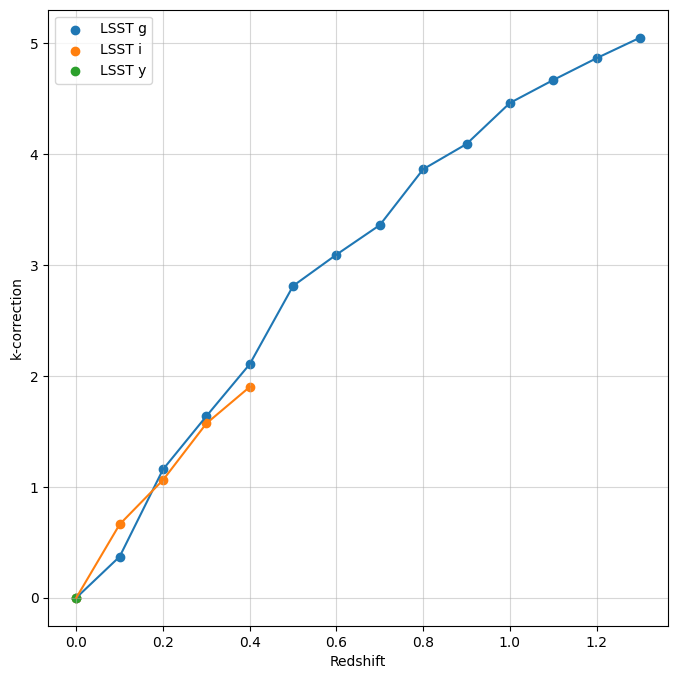

In [12]:
fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(z_grid[:len(k_by_filter[0])], k_by_filter[0], label="LSST g")
ax.plot(z_grid[:len(k_by_filter[0])], k_by_filter[0])

ax.scatter(z_grid[:len(k_by_filter[1])], k_by_filter[1], label="LSST i")
ax.plot(z_grid[:len(k_by_filter[1])], k_by_filter[1])

ax.scatter(z_grid[:len(k_by_filter[2])], k_by_filter[2], label="LSST y")
ax.plot(z_grid[:len(k_by_filter[2])], k_by_filter[2])

ax.set_xlabel("Redshift")
ax.set_ylabel("k-correction")
ax.legend()
ax.grid(alpha=0.5)

# Q2 - Supernovae and $H_0$ (40 pts - 10 per part)

For this simulation, we will generate a sample of type Ia supernovae. These are special as they have similar intrinsic brightness, so that their apparent flux can be used to measure how far away they are. If their redshift is also measured, the measurements can be used to calculate the expansion rate of the Universe, or Hubble's constant.

We want to understand *how* brightness limits affect the use of type Ia supernovae observations in the measurement of the Hubble constant, $H_0$. To do so, we will use Monte Carlo computations to generate a set of simulated data.

A subtle effect occurs in this measurement, called Malmquist bias, that can affect the result. The effect is caused by the range of apparent brightness for supernova. Supernova in our simulation have an absolute magnitude of M=-19.

Assume the supernova have a scatter about their absolute magnitude of approximately 1 magnitude (this is much too large, but it is to exaggerate the effect we'll see). 1-2m class survey telescopes will detect objects as faint as m=21 in about a minute of exposure - treat this is as their reliable detection limit - i.e. sources <= 21 are detected 100% of the time. Sources > 21 are detected with 0% efficiency. This is obviously unrealistic, but it'll suffice for now.

The limiting magnitude corresponds to a distance modulus m-M=5 log10(d/10 pc) of 40, which suggests that supernova can be seen at least as far away as 1000 Mpc.

(We will assume that over this distance, the SED of SNe Ia are approximately constant so we can happily neglect the $k$-correction, so you will not murder me after you have suffered through Q1)

Assume supernova are formed uniformly throughout *a sphere* with radius r=2500 Mpc. In the data generation part of the simulation, assume that each supernova is receding at a rate v=H0*d, where H0 is 72km/s/Mpc and d is the distance in Mpc. For each supernova you simulate, also create a peculiar velocity array that you can add to the recession velocity by drawing from a Gaussian distribution with mean 0, and standard deviation of 600 km/s. (Hint: "uniformly in a sphere" is definitely a trap and you should think about what you are doing)

1. Create a Monte Carlo program to generate 100 randomly placed supernovae within this volume. Have the program generate the true distances, $d$, to the supernovae. Calculate the mean distance for the supernovae.

2. Now assume each supernovae has a brightness governed by M = -19 +G(1) where G(1) is a random number with Gaussian distribution and standard deviation of one magnitude. Calculate the apparent magnitude of each supernovae using the distance generated in part (1). If m>21, assume the object is too faint to detect and reject it from the sample. Create a plot of magnitude versus distance for all the supernovae. Write out the *average* magnitudes of the original sample and the detected sample.

3. Generate the velocities (both recession and peculiar) as described earlier. Generate an observed distance ($d'$) by using its apparent magnitude and Hubble’s law, with the *assumption* that the supernova has an absolute magnitude (M) of -19. Plot the observed distance on the x-axis and total velocity on the y-axis and compare it to the true distance. Explain the effect of the observing limit on the resulting sample.

4. Calculate $H_0$ by fitting a line to all your detected points. Discuss the level of the bias from the fit you get to the true points. How much of an impact does the peculiar velocity have? How could you account for Malmquist bias and peculiar velocity in the observations? Repeat for N=1000, 10000 SNe (and as with Q1, make your code use approrpiate functions so you can just call it for different sample sizes) to see if the effects persist as a function of sample size.

In [13]:
# part 1
# generate the data. 100 samples within a sphere of radius 2500 Mpc
# In order to have r uniformly distributed within the sphere, we need to have x, y and z uniformly sampled, with the constraint that x^2+y^2+z^2<rmax^3
# Since x^2, y^2 and z^2 would be uniformly sampled, r^3 is a sum of uniformly sampled numbers (ie, a unformly sampled number)
# This translates to r^3 being uniformly sampled, rather than r

N=100
coords = np.random.uniform([0,0,0], [2500**3, np.pi, 2*np.pi], size=(N,3))
coords.shape
SNs = pd.DataFrame({"distance":coords[:,0]**(1/3), "theta":coords[:,1], "phi":coords[:,2]})

# print mean value for radius
SNs.describe()

,distance,theta,phi
count,100.000000,100.000000,100.000000
mean,1902.275730,1.495146,3.074197
std,440.150923,0.918650,1.882892
min,601.815096,0.007325,0.009496
25%,1550.701528,0.632113,1.394597
50%,1993.016944,1.587310,3.106435
75%,2270.363252,2.284568,4.659047
max,2497.429168,3.141407,6.216837


Magnitude of all supernovae: 22.491886822453683
Magnitude of detected supernovae: 20.422073818706227


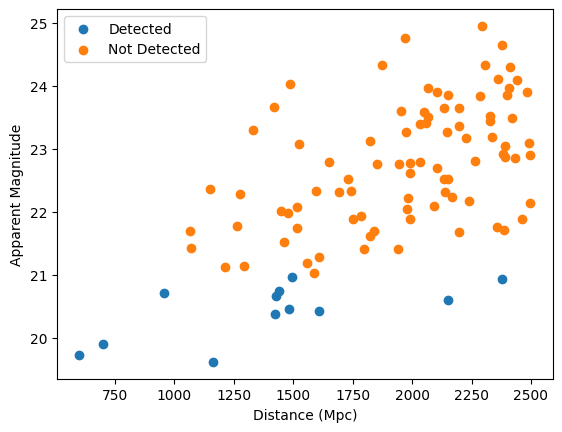

In [14]:
# part 2

# generate brightness for each SN
brightness = np.random.normal(loc=-19, scale=1, size=N)
SNs["brightness"]=brightness

# calculate aparent magnitude m using brightness M and distance d and the distance modulus formula
# m = M + 5 log10(d/10 pc)
# we must convert distance from Mpc to pc
SNs["mag_apparent"] = SNs["brightness"] + 5 * np.log10((SNs["distance"]*(10**6))/10)

# Then we filter values where apparent magnitude is higher than 21
mask = SNs["mag_apparent"]<21

SNs["detected"]=mask

fig,ax=plt.subplots()
ax.scatter(SNs["distance"][mask], SNs["mag_apparent"][mask], label="Detected")
ax.scatter(SNs["distance"][~mask], SNs["mag_apparent"][~mask], label="Not Detected")
ax.set_xlabel("Distance (Mpc)")
ax.set_ylabel("Apparent Magnitude")
plt.legend()

#display(SNs)
print(f"Magnitude of all supernovae: {SNs['mag_apparent'].mean()}")
print(f"Magnitude of detected supernovae: {SNs['mag_apparent'][mask].mean()}")

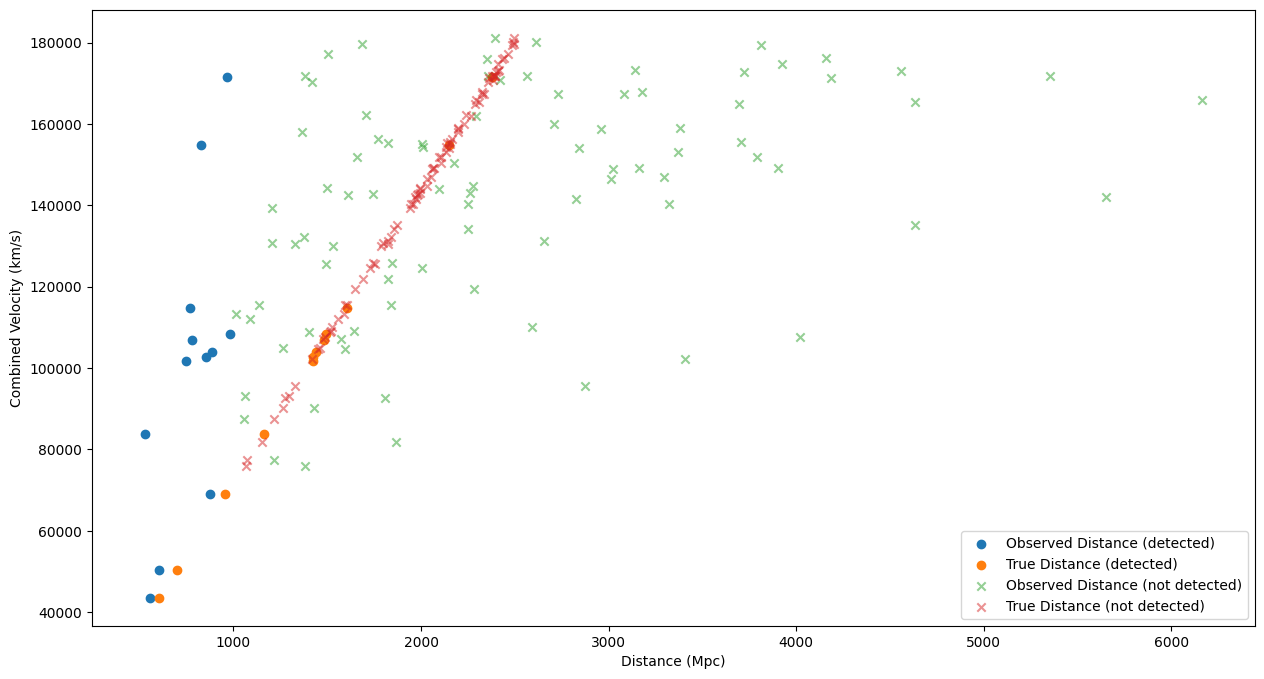

In [15]:
# part 3
# generate receding and peculiar velocities
H0 = 72 # km/s/Mpc
SNs["receding"] = H0 * SNs["distance"]
SNs["peculiar"] = np.random.normal(loc=0, scale=600, size=N)

# we then generate observed distances from the luminosity distance assuming M=-19 fixed for all supernovae
# Dl is calculated in parsecs, so we convert to Mpc
SNs["obs_dist (Mpc)"] = 10 ** (((SNs["mag_apparent"]-(-19))/5)+1) * (1e-6)

#display(SNs)
# Plot the observed distance on the x-axis and total velocity on the y-axis
fig,ax=plt.subplots(figsize=(15,8))
ax.scatter(SNs["obs_dist (Mpc)"][mask], (SNs["receding"]+SNs["peculiar"])[mask], label="Observed Distance (detected)")
ax.scatter(SNs["distance"][mask], (SNs["receding"]+SNs["peculiar"])[mask], label="True Distance (detected)")
ax.scatter(SNs["obs_dist (Mpc)"][~mask], (SNs["receding"]+SNs["peculiar"])[~mask], label="Observed Distance (not detected)", marker="x",alpha=0.5)
ax.scatter(SNs["distance"][~mask], (SNs["receding"]+SNs["peculiar"])[~mask], label="True Distance (not detected)", marker="x",alpha=0.5)
ax.set_xlabel("Distance (Mpc)")
ax.set_ylabel("Combined Velocity (km/s)")
ax.legend()

**Explain the effect of the observing limit on the resulting sample:** By applying the cut for m_apparent<21, we select objects that appear brighter, but since that correlates with distance to some extent, we end up with objects that are closer. This could skew the measurement of H0 since at low distances, the peculiar velocities have more influence in the object's combined velocity.

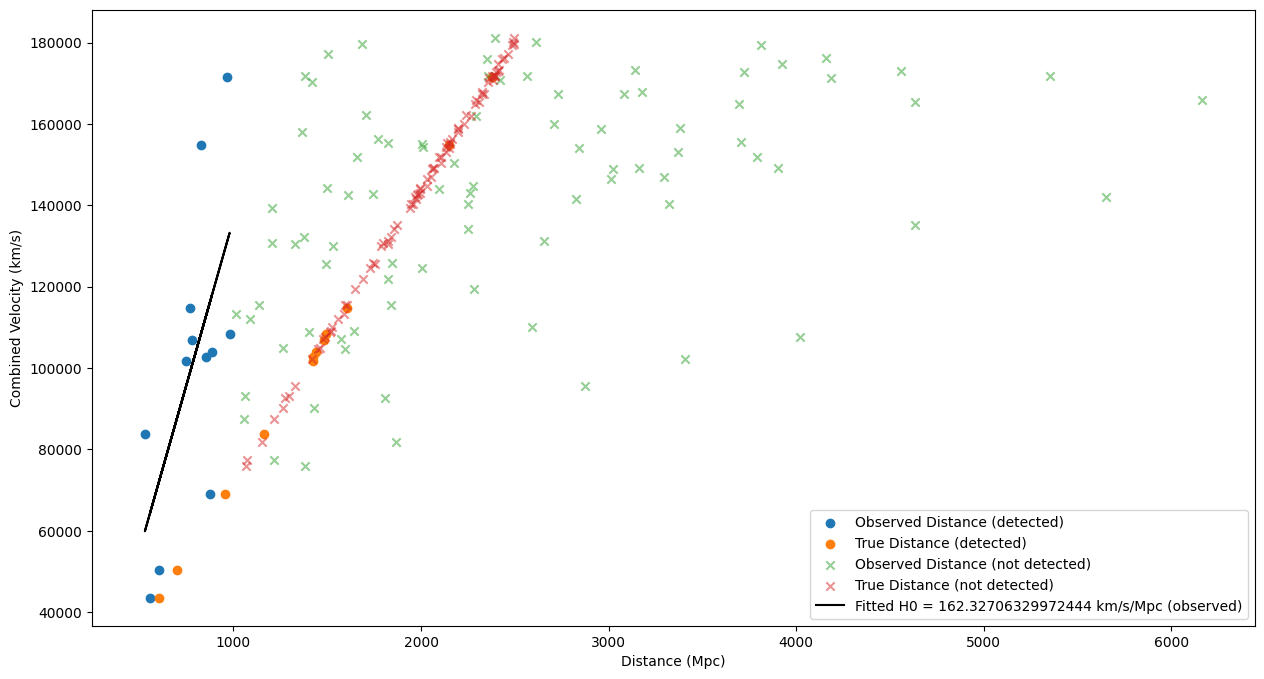

In [16]:
# Calculate H0 with detected points
observed_fitted_H0, intersect, _, _, _ = sp.stats.linregress(SNs["obs_dist (Mpc)"][mask], (SNs["peculiar"]+SNs["receding"])[mask])

all_fitted_H0, _, _, _, _ = sp.stats.linregress(SNs["obs_dist (Mpc)"], (SNs["peculiar"]+SNs["receding"]))


# Plot the observed distance on the x-axis and total velocity on the y-axis
fig,ax=plt.subplots(figsize=(15,8))
ax.scatter(SNs["obs_dist (Mpc)"][mask], (SNs["receding"]+SNs["peculiar"])[mask], label="Observed Distance (detected)")
ax.scatter(SNs["distance"][mask], (SNs["receding"]+SNs["peculiar"])[mask], label="True Distance (detected)")
ax.scatter(SNs["obs_dist (Mpc)"][~mask], (SNs["receding"]+SNs["peculiar"])[~mask], label="Observed Distance (not detected)", marker="x",alpha=0.5)
ax.scatter(SNs["distance"][~mask], (SNs["receding"]+SNs["peculiar"])[~mask], label="True Distance (not detected)", marker="x",alpha=0.5)
ax.plot(SNs["obs_dist (Mpc)"][mask], SNs["obs_dist (Mpc)"][mask] * observed_fitted_H0 + intersect, "k", label=f"Fitted H0 = {observed_fitted_H0} km/s/Mpc (observed)")
#ax.plot(SNs["obs_dist (Mpc)"], SNs["obs_dist (Mpc)"] * all_fitted_H0, "--k", label=f"Fitted H0 = {all_fitted_H0} km/s/Mpc (total)")
ax.set_xlabel("Distance (Mpc)")
ax.set_ylabel("Combined Velocity (km/s)")
ax.legend()

In [17]:
# create functions to run the same code again with different number of simulations
def generate_supernovae(N, max_r=2500):
    coords = np.random.uniform([0,0,0], [max_r**3, np.pi, 2*np.pi], size=(N,3))
    coords.shape
    supernovae = pd.DataFrame({"distance":coords[:,0]**(1/3), "theta":coords[:,1], "phi":coords[:,2]})
    return supernovae

def generate_brightness(supernovae, loc=-19, scale=1):
    brightness = np.random.normal(loc=loc, scale=scale, size=supernovae.shape[0])
    supernovae["brightness"]=brightness

def get_apparent_magnitudes(supernovae):
    supernovae["mag_apparent"] = supernovae["brightness"] + 5 * np.log10((supernovae["distance"]*(10**6))/10)

def mask_faint_SN(supernovae, mag_limit=21):
    mask = supernovae["mag_apparent"]<mag_limit
    supernovae["detected"]=mask

def generate_velocities(supernovae, loc_peculiar=0, scale_peculiar=600, H0=72):
    supernovae["receding"] = H0 * supernovae["distance"]
    supernovae["peculiar"] = np.random.normal(loc=loc_peculiar, scale=scale_peculiar, size=supernovae.shape[0])

def get_obs_dist(supernovae, absmag=-19):
    supernovae["obs_dist (Mpc)"] = 10 ** (((supernovae["mag_apparent"]-(absmag))/5)+1) * (1e-6)

def get_H0(supernovae):
    mask=supernovae["detected"]
    # Calculate H0 with detected points
    observed_fitted_H0, intersect, _, _, _ = sp.stats.linregress(supernovae["obs_dist (Mpc)"][mask], (supernovae["peculiar"]+supernovae["receding"])[mask])

    #all_fitted_H0, _, _, _, _ = sp.stats.linregress(supernovae["obs_dist (Mpc)"], (supernovae["peculiar"]+supernovae["receding"]))
    return observed_fitted_H0, intersect

def make_plot(supernovae, observed_fitted_H0, intersect):
    mask=supernovae["detected"]
    print(f"Mean radius for simulated supernovae: {np.mean(supernovae['distance'])}")
    print(f"Average Magnitude of all supernovae: {supernovae['mag_apparent'].mean()}")
    print(f"Average Magnitude of detected supernovae: {supernovae['mag_apparent'][mask].mean()}")

    fig,ax=plt.subplots(figsize=(15,8))
    ax.scatter(supernovae["obs_dist (Mpc)"][mask], (supernovae["receding"]+supernovae["peculiar"])[mask], label="Observed Distance (detected)")
    ax.scatter(supernovae["distance"][mask], (supernovae["receding"]+supernovae["peculiar"])[mask], label="True Distance (detected)")
    ax.scatter(supernovae["obs_dist (Mpc)"][~mask], (supernovae["receding"]+supernovae["peculiar"])[~mask], label="Observed Distance (not detected)", marker="x",alpha=0.5)
    ax.scatter(supernovae["distance"][~mask], (supernovae["receding"]+supernovae["peculiar"])[~mask], label="True Distance (not detected)", marker="x",alpha=0.5)
    ax.plot(supernovae["obs_dist (Mpc)"][mask], supernovae["obs_dist (Mpc)"][mask] * observed_fitted_H0 + intersect, "--k", label=f"Fitted H0 = {observed_fitted_H0} km/s/Mpc (observed)")
    ax.set_xlabel("Distance (Mpc)")
    ax.set_ylabel("Combined Velocity (km/s)")
    ax.legend()
    plt.show()

def run_simulation(N):
    SNs = generate_supernovae(N)
    generate_brightness(SNs)
    get_apparent_magnitudes(SNs)
    mask_faint_SN(SNs)
    generate_velocities(SNs)
    get_obs_dist(SNs)
    H0, intersect = get_H0(SNs)
    make_plot(SNs, H0, intersect)



Mean radius for simulated supernovae: 1857.5015903743863
Average Magnitude of all supernovae: 22.364243045211914
Average Magnitude of detected supernovae: 20.43331948089007


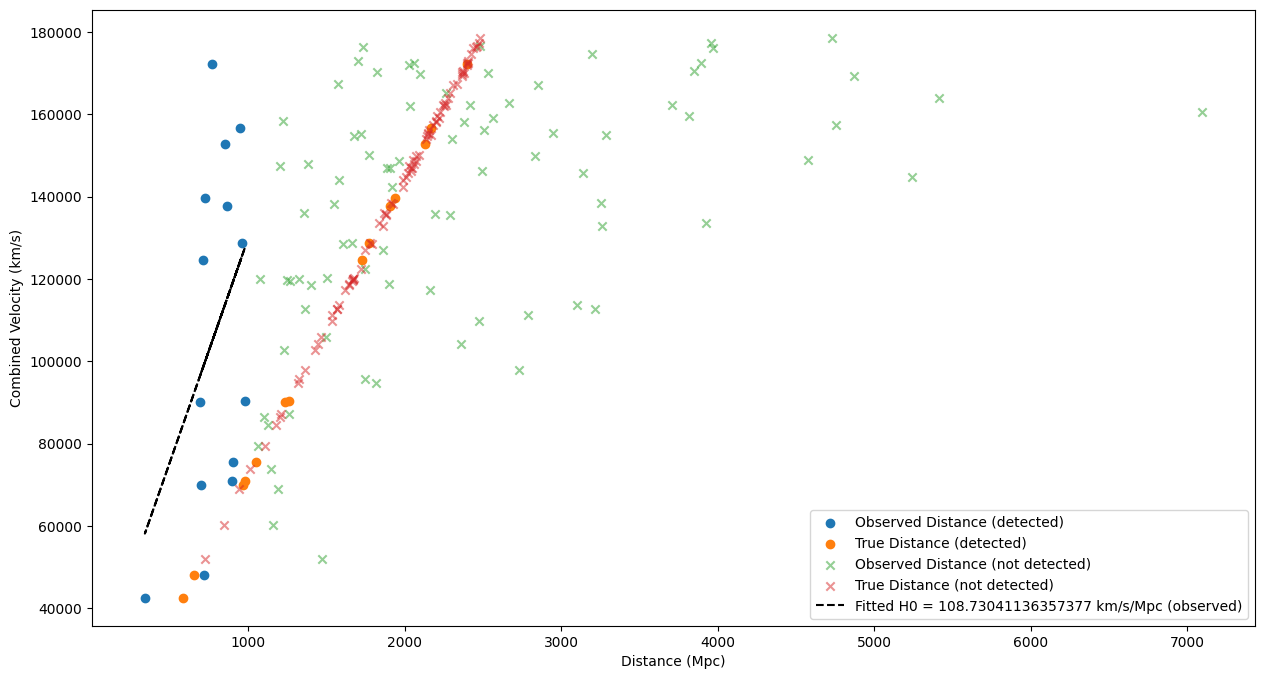

Mean radius for simulated supernovae: 1863.0159197261414
Average Magnitude of all supernovae: 22.08889083909365
Average Magnitude of detected supernovae: 20.161554704964125


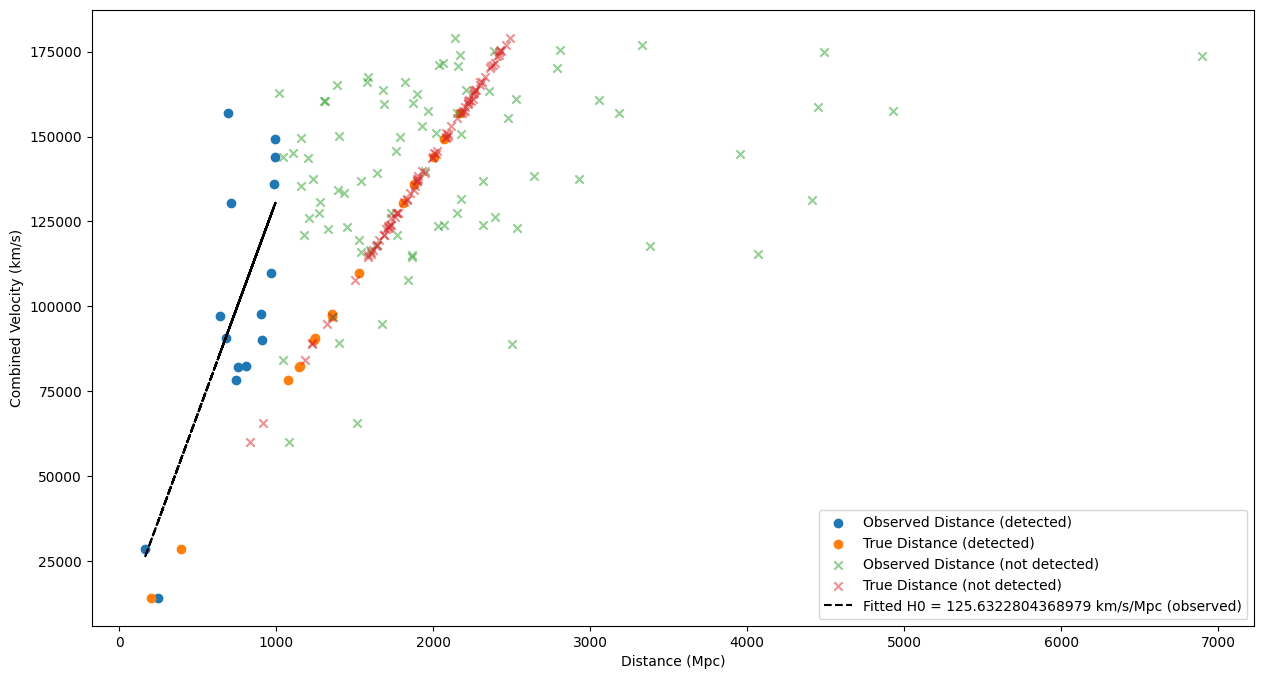

Mean radius for simulated supernovae: 1883.929031968685
Average Magnitude of all supernovae: 22.269415757922662
Average Magnitude of detected supernovae: 20.013466498126665


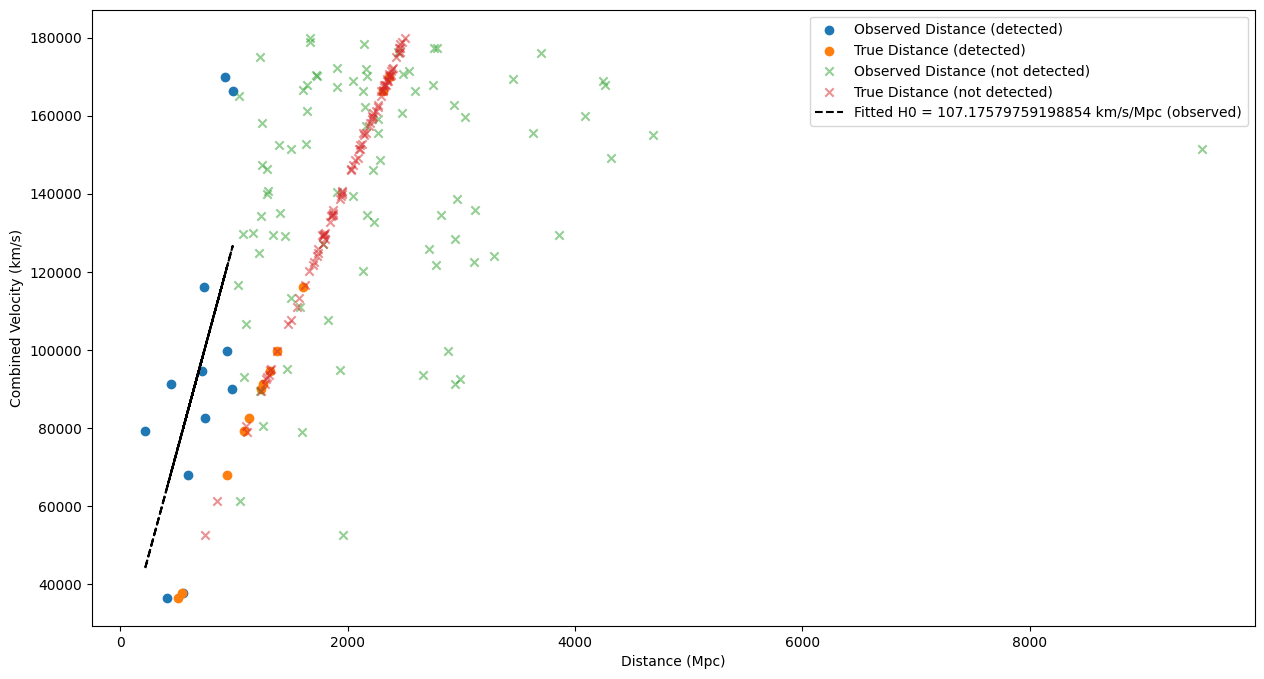

In [18]:
for i in range(3):
    run_simulation(100)

Mean radius for simulated supernovae: 1865.179043653559
Average Magnitude of all supernovae: 22.22922594213393
Average Magnitude of detected supernovae: 20.18133396196678


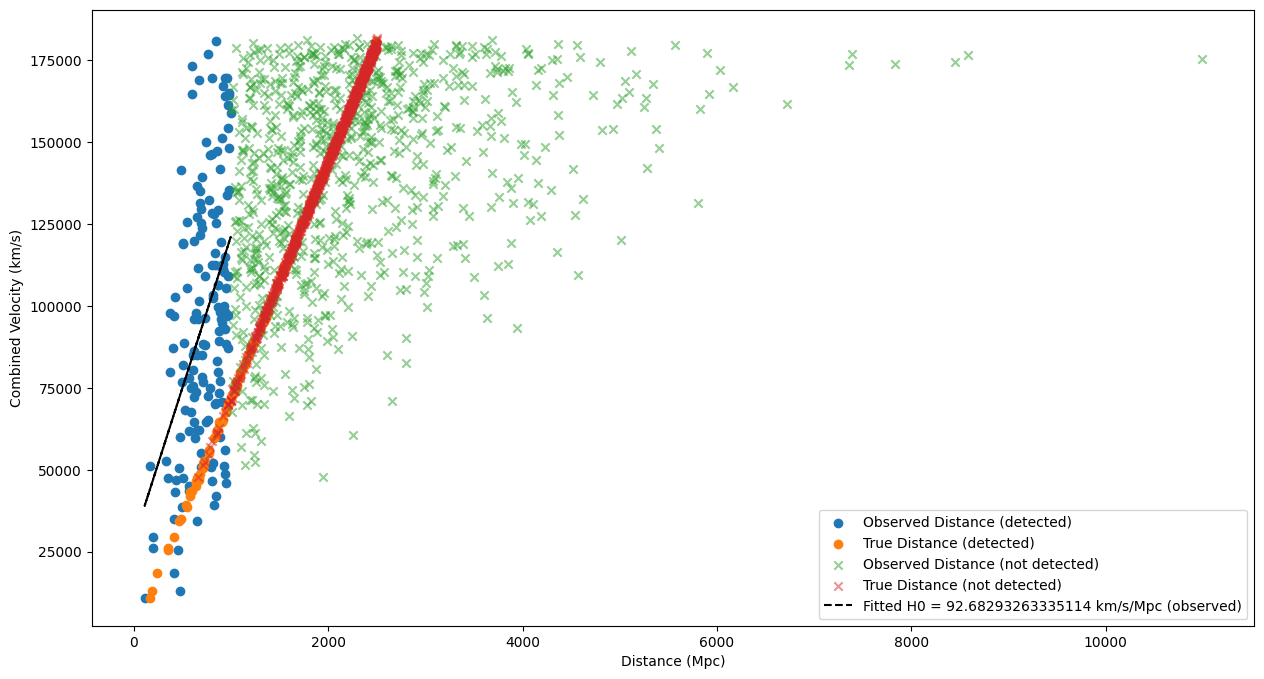

Mean radius for simulated supernovae: 1892.8475661362277
Average Magnitude of all supernovae: 22.279402824106626
Average Magnitude of detected supernovae: 20.310563915709007


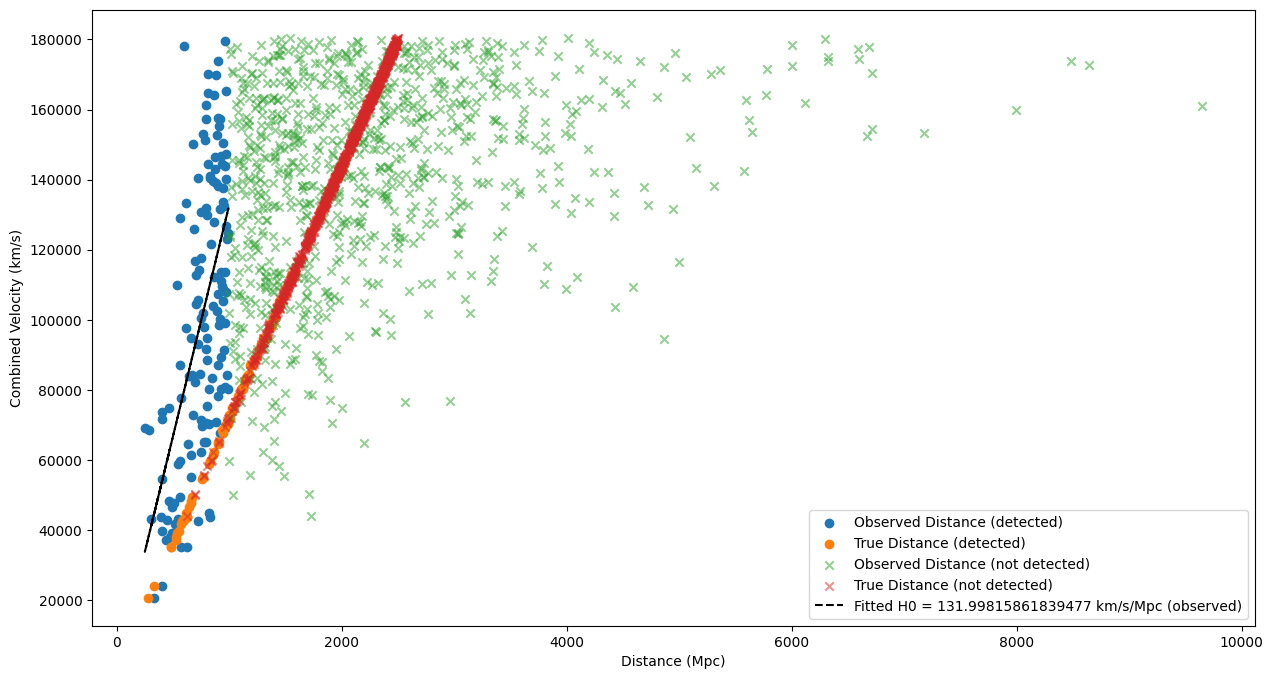

Mean radius for simulated supernovae: 1852.97956811069
Average Magnitude of all supernovae: 22.192373887885633
Average Magnitude of detected supernovae: 20.236323557796958


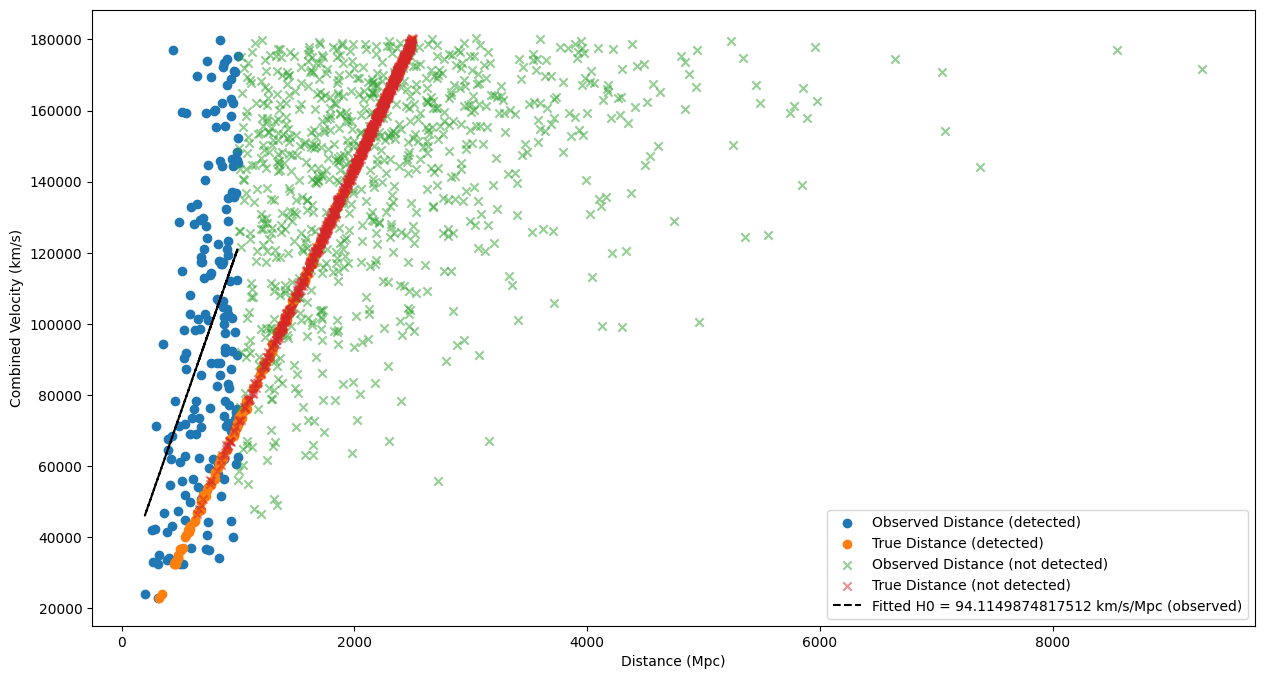

In [19]:
for i in range(3):
    run_simulation(1000)

Mean radius for simulated supernovae: 1873.925352080889
Average Magnitude of all supernovae: 22.259569588470395
Average Magnitude of detected supernovae: 20.205734929876844


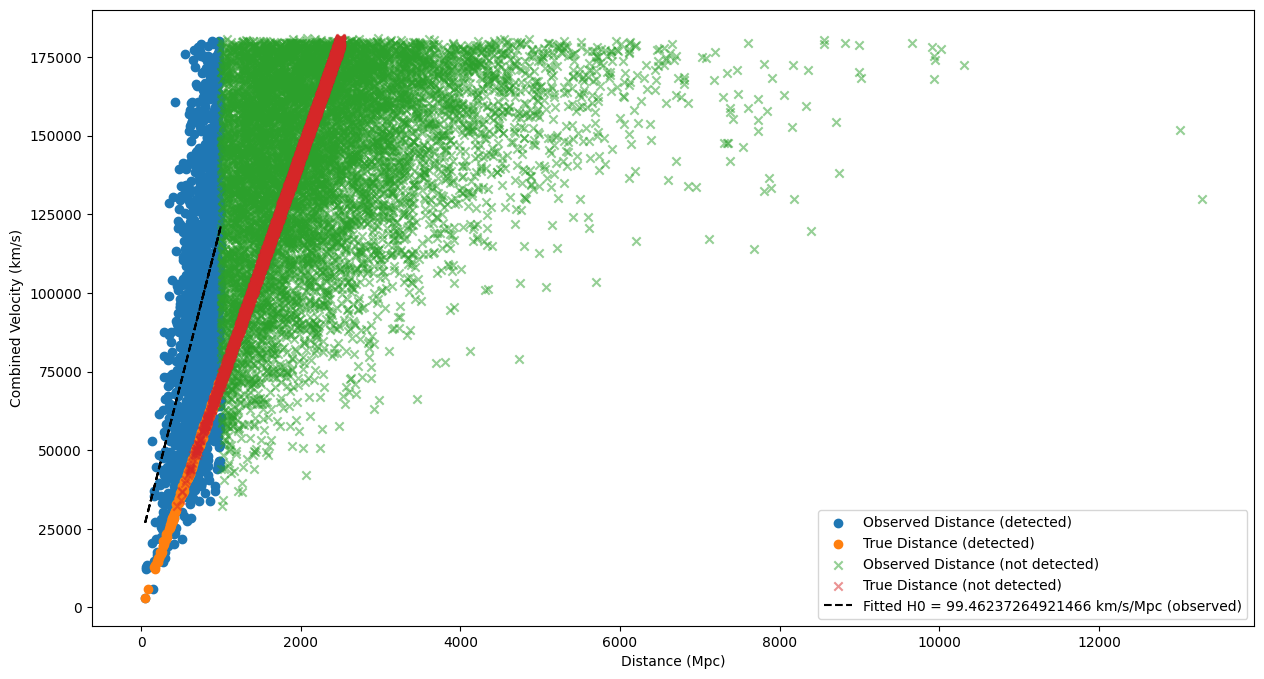

Mean radius for simulated supernovae: 1875.1344576425568
Average Magnitude of all supernovae: 22.264920698920236
Average Magnitude of detected supernovae: 20.221480466072038


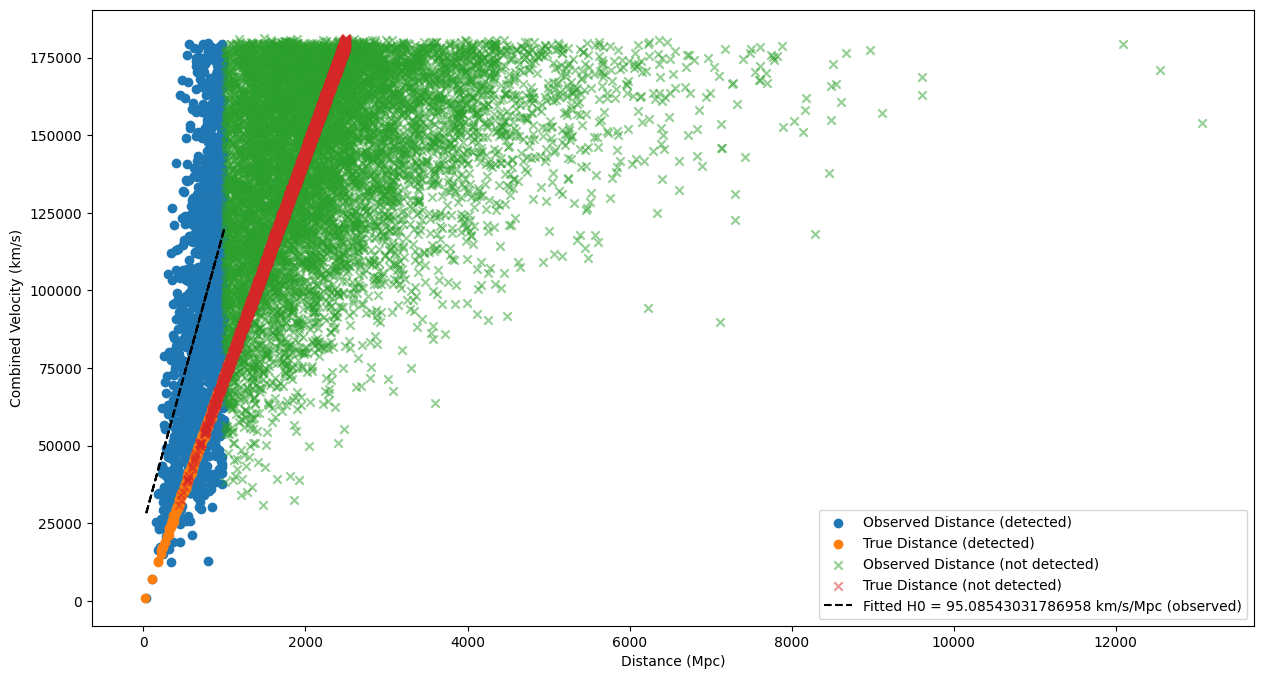

Mean radius for simulated supernovae: 1875.4974982267604
Average Magnitude of all supernovae: 22.27047124588466
Average Magnitude of detected supernovae: 20.231461248148513


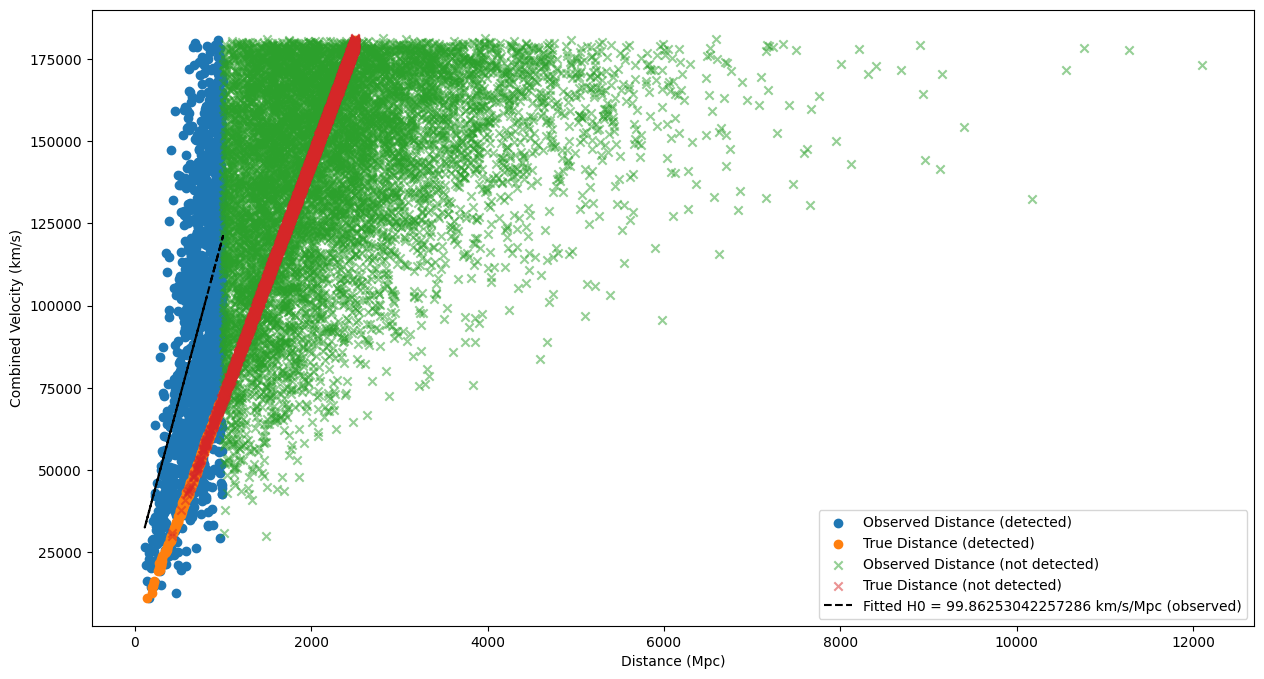

In [20]:
for i in range(3):
    run_simulation(10000)

**Discuss the level of the bias from the fit you get to the true points. How much of an impact does the peculiar velocity have? How could you account for Malmquist bias and peculiar velocity in the observations? Repeat for N=1000, 10000 SNe (and as with Q1, make your code use approrpiate functions so you can just call it for different sample sizes) to see if the effects persist as a function of sample size.**

As we can see from the final plots, for low n, the value of H0 varies a lot between different runs. This is due to the fact that we apply a very limiting cut on an already reduced sample size. For n=10000, we have a fitted value of H0 stabilizing in the 90~100 Km/s/Mpc range. The fit is clearly very biased, since the true value used to simulate data was 72 km/s/Mpc. This is a consequence of malmquist bias, since we sistematically underestimate the ditance of objects by removing fainter instances for any given distance. For low sample sizes, the scatter in peculiar velocity has a larger effect, but as n increases, the scatter is averaged out (random uncertainty), leaving mostly malquist bias (sistematic uncertainty). To account for Malmquist bias, one could consider the probability of detection of a given object as a function of distance and magnitude. The effect of peculiar velocities is averaged out as you get more data. If getting more data is impossible, then the peculiar velocities can be estimated.

### Divide and conquer, so you encounter issues in parallel and can explain things to each other, rather than working in series.

# Due Oct 1 at Noon!